In [84]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from torchsummary import summary
from torch.utils.data import DataLoader
from PIL import Image
from dataloader import WHU
from utils import dataset_split
from torchvision import transforms
from model import Segmentor
from utils import calculate_iou
from engine import train_val

Splitting dataset into train/test/val --> 280/60/60

In [ ]:
train_dir = "../Datasets/WHU-Bldg/dataset/train"
val_dir = "../Datasets/WHU-Bldg/dataset/val"
test_dir = "../Datasets/WHU-Bldg/dataset/test"

Checking the effect of downsizing the images

In [ ]:
index = 4
# Open the original image
image = Image.open(os.path.join(train_dir,f"Images/{index}.png")).convert("RGB")

trans = transforms.Compose([
    transforms.Resize((512, 512))  # Use a smaller size to see the downsizing effect
])

# Apply the transformation
image_2 = Image.open(os.path.join(train_dir,f"Masks/{index}.png"))

image = np.array(image)
image_2 = np.array(image_2)


fig , axs = plt.subplots(nrows= 1 , ncols=2 , figsize = (15,15))
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].set_axis_off()
axs[1].imshow(image_2 , cmap = 'gray')
axs[1].set_title("Mask")
axs[1].set_axis_off()
plt.show()

In [ ]:
#HYPERPARAMETERS
BATCH_SIZE = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.01
scheduler = "exponential"
epochs = 50

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),          # Randomly crop images to 224x224
    transforms.RandomHorizontalFlip(),          # Random horizontal flipping
    transforms.RandomRotation(10),              # Random rotation of +/- 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly jitter color
    transforms.ToTensor(),                      # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # Normalize for pretrained models
])

In [ ]:
train_dataset = WHU(parent_dir=train_dir)

val_dataset = WHU(parent_dir=val_dir)

test_dataset = WHU(parent_dir=test_dir)

In [78]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
len(train_loader) , len(test_loader) , len(val_loader)

(1184, 242, 259)

In [90]:
val_iter = iter(test_loader)
batch = next(val_iter)
images , masks = batch

In [ ]:
print(masks[0])

In [96]:
index = 2 # sample number from the batch
mask = masks[index].squeeze()
image = images[index]
image.shape

torch.Size([3, 512, 512])

In [ ]:
mask = mask.unsqueeze(dim = 0).permute(1 , 2 , 0)
mask = mask.numpy()
img = image.permute(1 , 2 , 0)
img = img.numpy()

fig , axs = plt.subplots(nrows = 1 , ncols = 2 , figsize = (10 , 10))
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis('off')
axs[1].imshow(mask)
axs[1].set_title("Mask")
axs[1].axis('off')
plt.show()


In [ ]:
model = Segmentor().to(device)
summary(model , input_size=( 3 , 512 , 512))

Training

In [ ]:
train_loss , train_iou , val_loss , val_iou = train_val(model = model , 
                                                        train_loader = train_loader, 
                                                        val_loader = val_loader, 
                                                        epochs = epochs, 
                                                        lr = lr, 
                                                        device = device , 
                                                        lr_schedule=scheduler , 
                                                        out_dir = "weights/resume/best_checkpoint.pth" , 
                                                        neptune_config="../neptune.json")

In [97]:
checkpoint = torch.load("weights/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
image = image.unsqueeze(0)
with torch.no_grad():
    outputs = model(image.to(device))


# Assuming `output_probs` is your model's output tensor with shape [1, 1, H, W]
# and contains probability values between 0 and 1 from a sigmoid activation
threshold = 0.5  # Commonly used threshold
binary_mask = (outputs > threshold).float()  # Convert to 0 or 1 based on the threshold
# Convert PyTorch tensor to numpy array
binary_mask = binary_mask.to('cpu')
binary_mask_np = binary_mask.numpy().squeeze()  # Squeeze out channel and batch dimensions if necessary

# Morphological closing to fill small holes
kernel = np.ones((3,3),np.uint8)  # You can adjust kernel size based on your needs
closed_mask = cv2.morphologyEx(binary_mask_np, cv2.MORPH_CLOSE, kernel)

# Morphological opening to remove noise
cleaned_mask = cv2.morphologyEx(closed_mask, cv2.MORPH_OPEN, kernel)

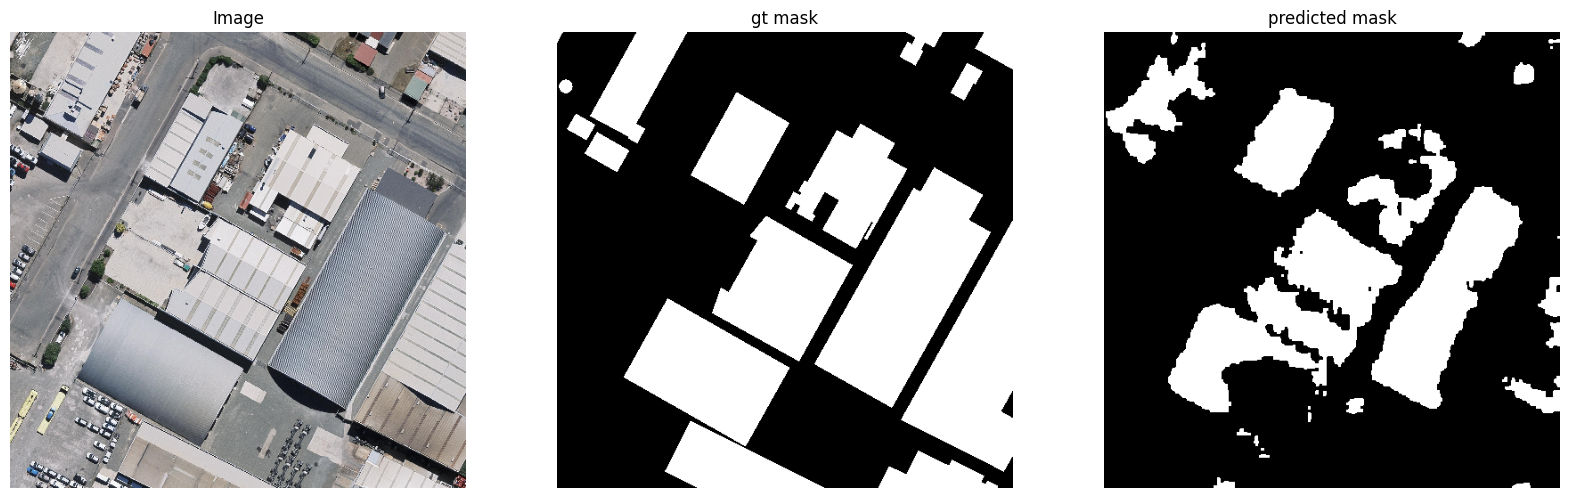

In [98]:
# outputs = outputs.squeeze()
# Convert the tensor to a numpy array for visualization
# predicted_labels = outputs.cpu().numpy()
image = image.squeeze().permute(1 , 2 , 0)
image = image.cpu().numpy()
# Convert the mask to a color image
# Visualize using matplotlib
fig , axs = plt.subplots(nrows = 1 , ncols=3 , figsize = (20 , 20))
axs[0].imshow(image)
axs[0].set_title("Image")
axs[0].set_axis_off()
axs[1].imshow(mask , cmap='viridis')
axs[1].set_title("gt mask")
axs[1].set_axis_off()
axs[2].imshow(cleaned_mask , cmap = 'viridis')
axs[2].set_title("predicted mask")
axs[2].set_axis_off()
plt.show()
